In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pickle
import itertools
import tqdm
# import hypergrad as hg
from mlmodel import *
import utils
import numpy as np
from sparsemax import Sparsemax
from argparse import ArgumentParser
from ZSTL_model import ZSTL
import pandas as pd

In [2]:
net = FuncRecursiveNet([
    FLinearLayer(1, True)
])
shape_record = {0: [(1, 2049)]}

In [3]:
kb_size = 10
train_size = 30

In [4]:
filename = '../ZSTL_Data/Animals_with_Attributes2/splitedTask/task_train_data_standard.pickle'
with open(filename, 'rb') as f:
    dataset = pickle.load(f)
print(len(dataset), len(list(dataset.keys())))
print(type(dataset))

total_len = len(dataset)
test_size = total_len - kb_size - train_size


# filename = '../ZSTL_Data/Animals_with_Attributes2/splitedTask/task_train_data_bin.pickle'
# with open(filename, 'rb') as f:
#     dataset = pickle.load(f)
# print(len(dataset), len(list(dataset.keys())))
# print(type(dataset))


50 50
<class 'dict'>


In [5]:
#check stored data correctness
def check_attr_correct(num_task, dataset, task_attr_byID, model):
    task_train_data = {}
    task_test_data = {}
    task_val_data = {}
    for t in range(num_task):
        cur_attr = dataset[t+1][0]
        cur_param = utils.toTensor(dataset[t+1][1])
        cur_x = utils.toTensor(dataset[t+1][2])
        cur_y = dataset[t+1][3]
        print((cur_attr==task_attr_byID[t+1]).all())


        reshaped_w = utils.reshape_w(cur_param, shape_record)
        pred = model(reshaped_w, cur_x)
        pred = torch.sigmoid(pred)
        pred[pred>=0.5] = torch.ones_like(pred[pred>=0.5])
        pred[pred<0.5] = torch.zeros_like(pred[pred<0.5])
        print(np.sum(utils.toNumpy(pred)==cur_y)/100)



In [6]:
path_attributes = '../ZSTL_Data/Animals_with_Attributes2/predicate-matrix-continuous.txt'
def gen_attr(path_attributes):
    data_attributes = pd.read_csv(path_attributes, sep="\n", header=None)
    print(data_attributes)
    lst = []
    task_attr_byID = {}
    i = 1
    for r in data_attributes.iterrows():
        # print(len(r), )
        s = r[1].to_numpy()
        # print(len(s[0].split()), s[0].split())
        print(len(s[0].split()))
        task_attr_byID[i] = np.array([float(a) for a in s[0].split()])
        print(task_attr_byID[i].shape)
        i += 1
    return task_attr_byID

#task_attr_byID = gen_attr(path_attributes)



In [7]:
#check_attr_correct(total_len, dataset, task_attr_byID, net)

In [8]:
indx = [ x+1 for x in range(len(dataset))]
support_indx = list(np.random.choice(indx, size=kb_size, replace=False))
print(len(support_indx))
temp = [x for x in indx if x not in support_indx]
train_indx = list(np.random.choice(temp, size=train_size, replace=False))
temp = [x for x in temp if x not in train_indx]
print(len(train_indx))
test_indx = temp
print(len(test_indx))


support_data = utils.Dataset([dataset[d] for d in support_indx])
train_data = utils.Dataset([dataset[d] for d in train_indx])
test_data = utils.Dataset([dataset[d] for d in test_indx])

10
30
10


In [9]:
support_loader = DataLoader(support_data, batch_size=kb_size, shuffle=False)
train_loader = DataLoader(train_data, batch_size=train_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_size, shuffle=True)
support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
print(support_a.size(), support_w.size(), support_x.size(), support_y.size())

torch.Size([10, 1, 85]) torch.Size([10, 1, 2049]) torch.Size([10, 200, 2049]) torch.Size([10, 200, 1])


In [10]:
support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
support_a = support_a.squeeze().t()
support_w = support_w.squeeze().t()
dm = support_a.size()[0]
d = support_w.size()[0]
print(d, dm)

param_dict = {}
param_dict['rho'] = 0.0005
param_dict['mu'] = 0.0001
param_dict['loss'] = 'binary class'
param_dict['outer lr'] = 5e-4
param_dict['align lr'] = 1e-4
param_dict['dm'] = dm
param_dict['d'] = d
param_dict['model_shape'] = shape_record
param_dict['atten_activation'] = 'Sparsemax'


ZSTL_model = ZSTL(support_w, support_a, support_x, net, param_dict)

2049 85


init mean test metric 0.509;
1/500 o_loss 2.177677678565184; mean test loss 0.514 with mse loss in atten align 0.17661869525909424
10/500 o_loss 0.9809321248282988; mean test loss 0.6395 with mse loss in atten align 0.1355578601360321
20/500 o_loss 0.6903039771442612; mean test loss 0.6655 with mse loss in atten align 0.14834456145763397
30/500 o_loss 0.5250608750929435; mean test loss 0.6425000000000001 with mse loss in atten align 0.10952339321374893
40/500 o_loss 0.4315492561707894; mean test loss 0.6749999999999999 with mse loss in atten align 0.09023182839155197
50/500 o_loss 0.36051556281745434; mean test loss 0.6165 with mse loss in atten align 0.12539631128311157
60/500 o_loss 0.32877274236331383; mean test loss 0.592 with mse loss in atten align 0.06357122957706451
70/500 o_loss 0.284075216576457; mean test loss 0.6405000000000001 with mse loss in atten align 0.09968301653862
80/500 o_loss 0.2563246458147963; mean test loss 0.5895 with mse loss in atten align 0.062538892030715

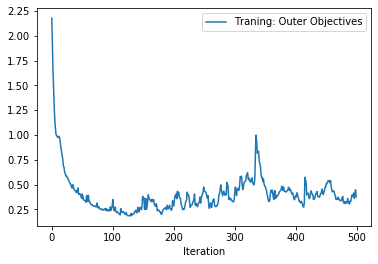

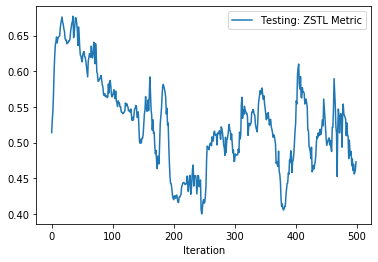

0

In [11]:
ZSTL_model.train(train_loader, test_loader, max_iter=500)

In [13]:
print(ZSTL_model.a_kb_opt.shape)

torch.Size([85, 10])
